In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import string
import nltk
import logic.processing as lp
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Flotchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Flotchi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Flotchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Flotchi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
path = os.getcwd()

In [5]:
rpath_train = os.path.join(os.path.dirname(path),'raw_data', 'drugsComTrain_raw.csv') 

In [6]:
df_train = pd.read_csv(rpath_train)

In [7]:
df_train.shape

(161297, 7)

In [8]:
rpath_test = os.path.join(os.path.dirname(path),'raw_data', 'drugsComTest_raw.csv') 

In [9]:
df_test = pd.read_csv(rpath_test)

In [10]:
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [11]:
def data_filter(df,top_conditions=25,uselfCount=0,min_length=10):
    
    df = df.dropna()
    condition_distribution = df['condition'].value_counts()
    top_conditions = condition_distribution.head(top_conditions)
    top_conditions_list = top_conditions.index.tolist()
    df = df[df['condition'].isin(top_conditions_list)]
    df = df[df['usefulCount']>uselfCount]
    df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
    df = df[df.review_length>=min_length]
    
    return df
    

In [12]:
def process(df):
    def clean(st):
        for punc in string.punctuation:
            st = st.replace(punc, '')
        ans = st.casefold().replace('\n', ' ')
        ansd = ''.join(x for x in ans if not x.isdigit())
        stop = set(stopwords.words('english'))
        tokens = word_tokenize(ansd)
        ansdd = [y for y in tokens if y not in stop]
        lemmaverb = [WordNetLemmatizer().lemmatize(word, pos='v') for word in ansdd]
        lemmanouns = [WordNetLemmatizer().lemmatize(word, pos='n') for word in lemmaverb]
        nans = ' '.join(lemmanouns)
        return nans
    df['review clean'] = df.review.apply(clean)
    return df

In [13]:
df_filter_train = data_filter(df_train)
df_filter_test = data_filter(df_test)

In [14]:
df_filter_train.shape

(95630, 8)

In [15]:
df_filter_train.nunique()

uniqueID         95630
drugName          1120
condition           25
review           65639
rating              10
date              3573
usefulCount        377
review_length      287
dtype: int64

In [16]:
df_proc_train = process(df_filter_train)

In [17]:
df_proc_test = process(df_filter_test)

In [18]:
X_train = df_proc_train['review clean']
y_train = df_proc_train['condition']

In [19]:
X_test = df_proc_test['review clean']
y_test = df_proc_test['condition']

In [20]:
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
    ('oversample', RandomOverSampler(random_state=42)),
    ('nb', MultinomialNB(alpha=0.1))
])
pipeline

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
                ('oversample', RandomOverSampler(random_state=42)),
                ('nb', MultinomialNB(alpha=0.1))])

In [21]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
                ('oversample', RandomOverSampler(random_state=42)),
                ('nb', MultinomialNB(alpha=0.1))])

In [22]:
y_pred = pipeline.predict(X_test)

In [23]:
cm = confusion_matrix(y_test, y_pred)

<Figure size 1000x800 with 0 Axes>

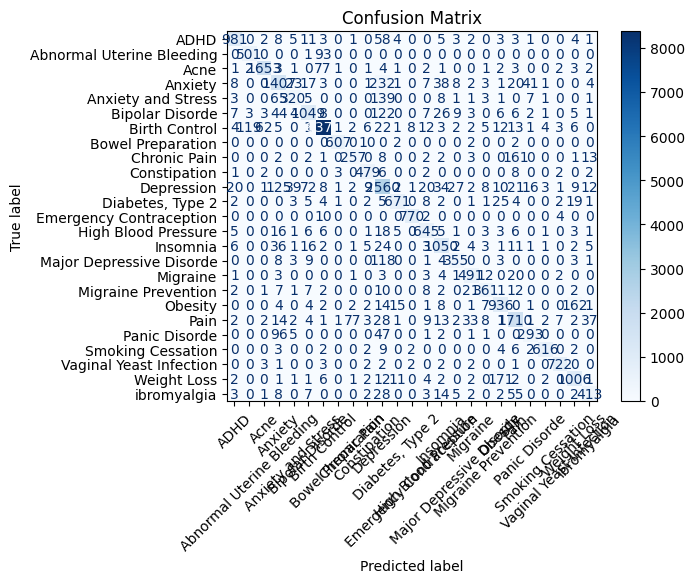

In [24]:
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
cm_display.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

                     ADHD       0.94      0.90      0.92      1095
Abnormal Uterine Bleeding       0.80      0.84      0.82       595
                     Acne       0.96      0.94      0.95      1760
                  Anxiety       0.76      0.77      0.77      1817
       Anxiety and Stress       0.78      0.58      0.66       555
          Bipolar Disorde       0.86      0.80      0.83      1306
            Birth Control       0.97      0.97      0.97      8666
        Bowel Preparation       0.99      0.97      0.98       623
             Chronic Pain       0.75      0.57      0.65       452
             Constipation       0.91      0.95      0.93       505
               Depression       0.74      0.85      0.79      3003
         Diabetes, Type 2       0.94      0.89      0.91       756
  Emergency Contraception       0.98      0.98      0.98       786
      High Blood Pressure       0.87      0.89      0.88     

Let's try it out!

In [26]:
my_symptoms = ["headaches, fatigue, irritability, drowsiness, memory loss, slowed thinking, slurred speech, impaired coordination of movements, dizziness,"]

In [27]:
prediction = pipeline.predict(my_symptoms)
prediction[0]

'Migraine Prevention'

In [28]:
prediction_prob = pipeline.predict_proba(my_symptoms)
prediction_prob

array([[4.01340180e-03, 1.55808944e-04, 5.51914613e-06, 1.83092294e-01,
        1.08793629e-01, 1.48792050e-01, 5.61966778e-04, 1.40158233e-06,
        2.15994537e-04, 1.19401270e-06, 4.19399575e-02, 7.85645554e-03,
        1.85367589e-05, 3.95174025e-02, 4.99468724e-02, 1.17451492e-02,
        2.09053099e-02, 3.43350671e-01, 9.74479767e-04, 5.27916686e-03,
        4.37383094e-04, 7.05272277e-04, 3.14779541e-07, 4.37606164e-03,
        2.73137072e-02]])

In [29]:
labels = pipeline.named_steps['nb'].classes_

print("Probabilities for the new text:")
for label, prob in zip(labels, prediction_prob[0]):
    print(f"  {label}: {prob:.4f}")

Probabilities for the new text:
  ADHD: 0.0040
  Abnormal Uterine Bleeding: 0.0002
  Acne: 0.0000
  Anxiety: 0.1831
  Anxiety and Stress: 0.1088
  Bipolar Disorde: 0.1488
  Birth Control: 0.0006
  Bowel Preparation: 0.0000
  Chronic Pain: 0.0002
  Constipation: 0.0000
  Depression: 0.0419
  Diabetes, Type 2: 0.0079
  Emergency Contraception: 0.0000
  High Blood Pressure: 0.0395
  Insomnia: 0.0499
  Major Depressive Disorde: 0.0117
  Migraine: 0.0209
  Migraine Prevention: 0.3434
  Obesity: 0.0010
  Pain: 0.0053
  Panic Disorde: 0.0004
  Smoking Cessation: 0.0007
  Vaginal Yeast Infection: 0.0000
  Weight Loss: 0.0044
  ibromyalgia: 0.0273
